In [1]:
import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: arunpandian7 (use `wandb login --relogin` to force relogin)


True

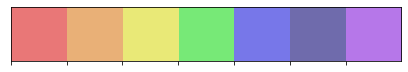

In [2]:
import os
import gc


import ast
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from utils import show_values_on_bars
%matplotlib inline


# Custom colors
my_colors = ["#E97777", "#E9B077", "#E9E977", 
             "#77E977", "#7777E9", "#6F6BAC", "#B677E9"]
sns.palplot(sns.color_palette(my_colors))

# Set Style
sns.set_style("white")
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.rcParams.update({'font.size': 22})

class color:
    BOLD = '\033[1m' + '\033[93m'
    END = '\033[0m'

In [3]:
DATA_DIR = "./dataset/resized-256/train/"
IMG_SIZE = 256
NUM_SAMPLES_TO_SELECT = 32

In [4]:
train_image_df = pd.read_csv("./dataset/train_image_level.csv")

train_label_df = pd.read_csv("./dataset/train_study_level.csv")

# Modify values in the id column
train_image_df['id'] = train_image_df.apply(lambda row: row.id.split('_')[0], axis=1)
# Add absolute path
train_image_df['path'] = train_image_df.apply(lambda row: DATA_DIR+row.id+'.jpg', axis=1)
# Get image level labels
train_image_df['image_level'] = train_image_df.apply(lambda row: row.label.split(' ')[0], axis=1)

# Modify values in the id column
train_label_df['id'] = train_label_df.apply(lambda row: row.id.split('_')[0], axis=1)
# Rename the column id with StudyInstanceUID
train_label_df.columns = ['StudyInstanceUID', 'Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']

# Merge both dataframes
train_image_df = train_image_df.merge(train_label_df, on='StudyInstanceUID',how="left")
train_image_df.head(2)

,id,boxes,label,StudyInstanceUID,path,image_level,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,./dataset/resized-256/train/000a312787f2.jpg,opacity,0,1,0,0
1,000c3a3f293f,NaN,none 1 0 0 1 1,ff0879eb20ed,./dataset/resized-256/train/000c3a3f293f.jpg,none,1,0,0,0


In [5]:
print(f'Number of unique image in training dataset: {len(train_image_df)}')

bbox_nan_num = train_image_df['boxes'].isna().sum()
print(f'Number of images without any bbox annotation: {bbox_nan_num}')

Number of unique image in training dataset: 6334
Number of images without any bbox annotation: 2040


In [6]:
# Label encode study-level labels
labels = train_image_df[['Negative for Pneumonia','Typical Appearance','Indeterminate Appearance','Atypical Appearance']].values
labels = np.argmax(labels, axis=1)

train_image_df['study_level'] = labels
train_image_df.head(2)

,id,boxes,label,StudyInstanceUID,path,image_level,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,study_level
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,./dataset/resized-256/train/000a312787f2.jpg,opacity,0,1,0,0,1
1,000c3a3f293f,NaN,none 1 0 0 1 1,ff0879eb20ed,./dataset/resized-256/train/000c3a3f293f.jpg,none,1,0,0,0,0


In [7]:
class_label_to_id = {
    'Negative for Pneumonia': 0,
    'Typical Appearance': 1,
    'Indeterminate Appearance': 2,
    'Atypical Appearance': 3
}

class_id_to_label = {val: key for key, val in class_label_to_id.items()}

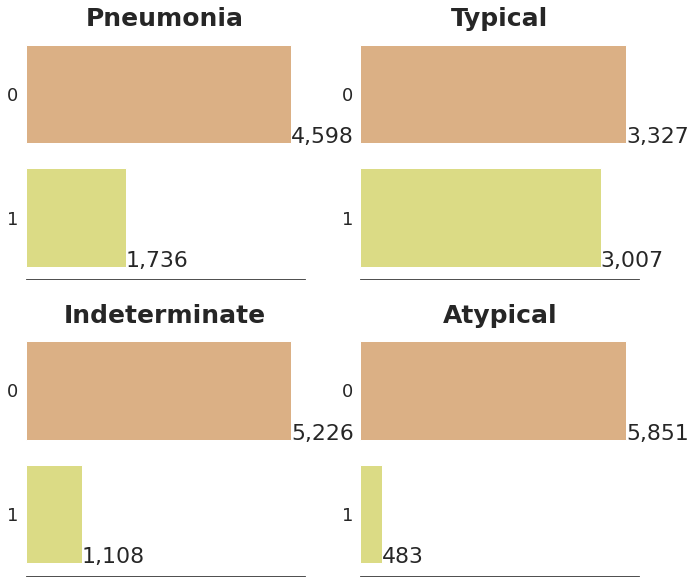

In [8]:
# Data for plots
pneumonia = train_image_df["Negative for Pneumonia"]
typical = train_image_df["Typical Appearance"]
indeterminate = train_image_df["Indeterminate Appearance"]
atypical = train_image_df["Atypical Appearance"]

# Plotting
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11,10))
axs = [ax1, ax2, ax3, ax4]
dfs = [pneumonia, typical, indeterminate, atypical]
titles = ["Pneumonia", "Typical", "Indeterminate", "Atypical"]

for ax, df, title in zip(axs, dfs, titles):
    sns.countplot(y=df, ax=ax, palette=my_colors[1:])
    ax.set_title(title, fontsize=25, weight='bold')
    show_values_on_bars(ax, h_v="h", space=0.4)
    ax.set_xticklabels([])
    ax.set_ylabel('')
    ax.set_xlabel('')

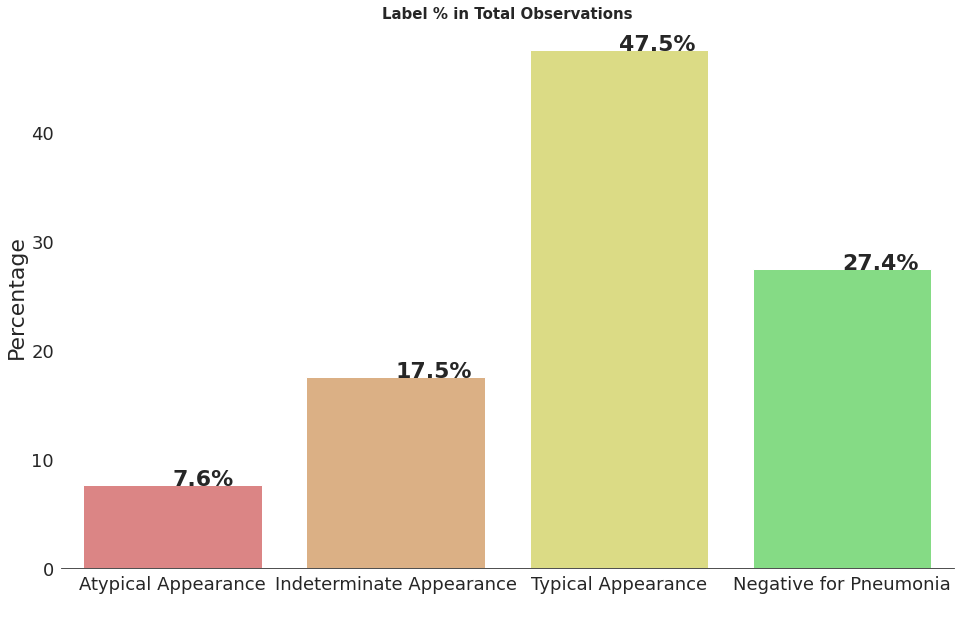

In [9]:
# Get data and transform frequencies to percentages
df = train_image_df.groupby(['Negative for Pneumonia', 'Typical Appearance',
       'Indeterminate Appearance', 'Atypical Appearance']).count().reset_index()

df["label"] = ['Atypical Appearance', 'Indeterminate Appearance',
               'Typical Appearance', 'Negative for Pneumonia']
df["perc"] = df["id"]/df["id"].sum()*100

# Plot
bar,ax = plt.subplots(figsize=(16,10))
ax = sns.barplot(x=df["label"], y=df["perc"], 
                 ci=None, palette=my_colors, orient='v')
ax.set_title("Label % in Total Observations", fontsize=15,
             weight = "bold")
ax.set_xlabel(" ")
ax.set_ylabel("Percentage")
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width() / 2,rect.get_height(),
             "%.1f%%"% rect.get_height(), weight='bold')

Text(0.5, 0, '')

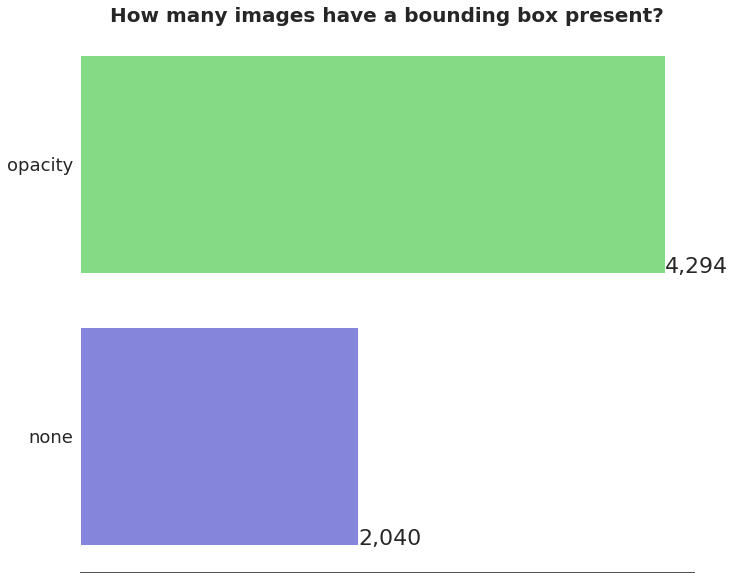

In [10]:
# Data for plotting
df = train_image_df["label"].apply(lambda x: x.split(" ")[0]).\
                                    value_counts().reset_index()

# Plot
plt.figure(figsize=(11, 10))
ax = sns.barplot(data=df, y="index", x="label", palette=my_colors[3:])
show_values_on_bars(ax, h_v="h", space=0.3)
plt.title("How many images have a bounding box present?", 
          fontsize=20, weight='bold')
plt.xticks([])
plt.ylabel('')
plt.xlabel('')

Max number of images available per study: 9 
Min number of images available per study: 1 




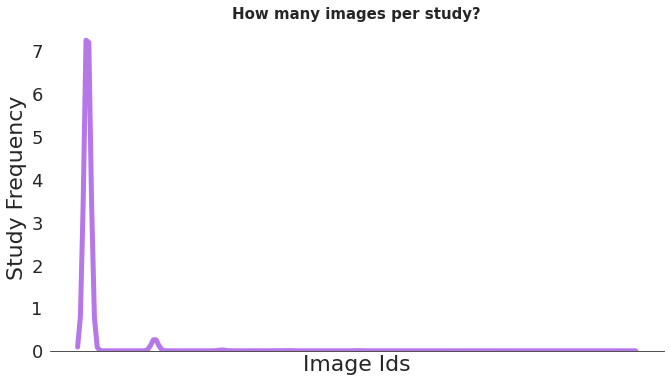

In [11]:
# Crate df
df = train_image_df["StudyInstanceUID"].value_counts().reset_index().\
                        sort_values("StudyInstanceUID", ascending=False)
print(color.BOLD + "Max number of images available per study:" + color.END, 
      df["StudyInstanceUID"].max(), "\n" +
      color.BOLD + "Min number of images available per study:" + color.END, 
      df["StudyInstanceUID"].min(), 2*"\n")
# Plot
plt.figure(figsize=(11, 6))
sns.distplot(a=df["StudyInstanceUID"], color=my_colors[6], 
             hist=False, kde_kws=dict(lw=5, ls="-"))
plt.title("How many images per study?", 
          fontsize=15, weight='bold')
plt.xticks([])
plt.ylabel('Study Frequency')
plt.xlabel('Image Ids');

In [12]:
# Load meta.csv file
meta_df = pd.read_csv('./dataset/resized-256/meta.csv')
train_meta_df = meta_df.loc[meta_df.split == 'train']
train_meta_df.columns = ['id', 'dim0', 'dim1', 'split']
train_meta_df.head(2)

,id,dim0,dim1,split
1263,d8ba599611e5,2336,2836,train
1264,29b23a11d1e4,3488,4256,train


In [13]:
train_image_df = train_image_df.merge(train_meta_df, on='id',how="left")
train_image_df.head(5)

,id,boxes,label,StudyInstanceUID,path,image_level,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,study_level,dim0,dim1,split
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,./dataset/resized-256/train/000a312787f2.jpg,opacity,0,1,0,0,1,3488,4256,train
1,000c3a3f293f,NaN,none 1 0 0 1 1,ff0879eb20ed,./dataset/resized-256/train/000c3a3f293f.jpg,none,1,0,0,0,0,2320,2832,train
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,./dataset/resized-256/train/0012ff7358bc.jpg,opacity,0,1,0,0,1,2544,3056,train
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,./dataset/resized-256/train/001398f4ff4f.jpg,opacity,0,0,0,1,3,3520,4280,train
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,./dataset/resized-256/train/001bd15d1891.jpg,opacity,0,1,0,0,1,2800,3408,train


In [14]:
# Since there are over 2000 rows without bounding box coordinates.
opacity_df = train_image_df.dropna(subset = ["boxes"], inplace=False)
opacity_df = opacity_df.reset_index(drop=True)

In [18]:
from utils import scale_bbox, wandb_bbox, get_bbox

sampled_df = opacity_df.sample(NUM_SAMPLES_TO_SELECT).reset_index(drop=True)

run = wandb.init(project='covid-project', 
                 config={'competition': 'siim-fisabio-rsna', '_wandb_kernel': 'arunrk7'},
                 job_type='visualize_sample_bbox',
                 name="bbox_visualizing")

wandb_bbox_list = []
for i in tqdm(range(NUM_SAMPLES_TO_SELECT)):
    row = sampled_df.loc[i]
    # Load image
    image = cv2.imread(row.path)
    # Get bboxes
    bboxes = get_bbox(row)
    # Scale bounding boxes
    scale_bboxes = scale_bbox(IMG_SIZE, row, bboxes)
    # Get ground truth label
    true_label = row.study_level
    
    wandb_bbox_list.append(wandb_bbox(image, 
                                      scale_bboxes, 
                                      true_label, 
                                      class_id_to_label))
    
wandb.log({"radiograph": wandb_bbox_list})

run.finish()

run

100%|██████████| 32/32 [00:00<00:00, 43.52it/s]


In [19]:
# W&B image
def wandb_bbox(image, bboxes, true_label, class_id_to_label, class_set):
    all_boxes = []
    for bbox in bboxes:
        box_data = {"position": {
                        "minX": bbox[0],
                        "minY": bbox[1],
                        "maxX": bbox[2],
                        "maxY": bbox[3]
                    },
                     "class_id" : int(true_label),
                     "box_caption": class_id_to_label[true_label],
                     "domain" : "pixel"}
        all_boxes.append(box_data)
    

    return wandb.Image(image, boxes={
        "ground_truth": {
            "box_data": all_boxes,
          "class_labels": class_id_to_label
        }
    }, classes=class_set)

In [22]:
run = wandb.init(project='covid-project', 
                 config={'competition': 'siim-fisabio-rsna', '_wandb_kernel': 'arunrk7'},
                 job_type='visualize-everything',
                 name="visualizing-table-view")

class_set = wandb.Classes([{'id': id, 'name': name} for id, name in class_id_to_label.items()])


table = wandb.Table(columns=['ImageID', 'StudyInstanceUID', 'Radiogram', 'image-label', 'study-label',
                             'Negative', 'Typical', 'Indeterminate', 'Atypical',
                             'ori_dim0', 'ori_dim1', 'split'])

# create an artifact for all the raw data
viz_at = wandb.Artifact('eda', type="basic-eda")

for i in tqdm(range(len(train_image_df))):
    row = train_image_df.loc[i]
    # Load image
    image = cv2.imread(row.path)
    # Get bboxes
    bboxes = get_bbox(row)
    # Scale bounding boxes
    scale_bboxes = scale_bbox(IMG_SIZE, row, bboxes)
    # Get ground truth label
    true_label = row.study_level
    # Get image with bounding boxes
    wandb_img = wandb_bbox(image, 
                           scale_bboxes, 
                           true_label, 
                           class_id_to_label,
                           class_set)
    
    # Add info in the table as new row
    table.add_data(row.id, row.StudyInstanceUID, wandb_img, row.image_level, row.study_level,
                   row['Negative for Pneumonia'], row['Typical Appearance'], row['Indeterminate Appearance'], row['Atypical Appearance'],
                   row.dim0, row.dim1, row.split)
    
    del row, wandb_img
    _ = gc.collect()
    
# wandb.log({'radiogram_eda': table})
viz_at.add(table, "Radiogram EDA")
run.log_artifact(viz_at)
run.finish()

100%|██████████| 6334/6334 [13:29<00:00,  7.83it/s]
